# 🔗 Proyecto de Detección de Fraude - Google Colab

In [5]:
# ✅ Clonar el repositorio (asegúrate de que sea público)
!git clone https://github.com/solivare/DeepNeuralNetworkUSS.git
%cd DeepNeuralNetworkUSS/Examples/Fraud


C:\Users\USS\DeepNeuralNetworkUSS\Examples\Fraud\notebooks\DeepNeuralNetworkUSS\Examples\Fraud


fatal: destination path 'DeepNeuralNetworkUSS' already exists and is not an empty directory.
C:\Users\USS\anaconda3\envs\tfenv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
# ✅ Instalar librerías necesarias
!pip install -r requirements.txt


In [7]:
# ✅ Descargar el dataset desde Google Drive (archivo ya compartido públicamente)
!pip install -q gdown
!mkdir -p data
!gdown --id 1KVCoiYWN9mtDnQhhqDNeEpDr9Az9jKVa -O data/creditcard.csv


Ya existe el subdirectorio o el archivo -p.
Error mientras se procesaba: -p.
Ya existe el subdirectorio o el archivo data.
Error mientras se procesaba: data.
C:\Users\USS\anaconda3\envs\tfenv\lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1KVCoiYWN9mtDnQhhqDNeEpDr9Az9jKVa
From (redirected): https://drive.google.com/uc?id=1KVCoiYWN9mtDnQhhqDNeEpDr9Az9jKVa&confirm=t&uuid=4f5c1a50-c718-4f36-8e59-131aa0ab1635
To: C:\Users\USS\DeepNeuralNetworkUSS\Examples\Fraud\notebooks\DeepNeuralNetworkUSS\Examples\Fraud\data\creditcard.csv

  0%|          | 0.00/151M [00:00<?, ?B/s]
  4%|4         | 6.29M/151M [00:00<00:02, 55.9MB/s]
 10%|#         | 15.2M/151M [00:00<00:01, 73.5MB/s]
 16%|#5        | 24.1M/151M [00:00<00:01, 79.9MB/s]
 23%|##2       | 34.1M/151M [00:00<00:01, 83.3MB/s]
 29%|

In [8]:
# ✅ Procesar los datos
!python src/preprocess.py


Dataset original: 284807 filas, 31 columnas


Traceback (most recent call last):
  File "C:\Users\USS\DeepNeuralNetworkUSS\Examples\Fraud\notebooks\DeepNeuralNetworkUSS\Examples\Fraud\src\preprocess.py", line 59, in <module>
    load_and_preprocess_data(config)
  File "C:\Users\USS\DeepNeuralNetworkUSS\Examples\Fraud\notebooks\DeepNeuralNetworkUSS\Examples\Fraud\src\preprocess.py", line 41, in load_and_preprocess_data
    print("\u2705 Archivos completos guardados (train_full, val, test)")
  File "C:\Users\USS\anaconda3\envs\tfenv\lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
UnicodeEncodeError: 'charmap' codec can't encode character '\u2705' in position 0: character maps to <undefined>


In [9]:
# ✅ Entrenar modelo NN
!python -c "import src.train as train; train.train()"

2025-07-25 05:23:03.353317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2025-07-25 05:23:03.353386: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-07-25 05:23:17.159984: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2025-07-25 05:23:17.161380: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2025-07-25 05:23:17.162993: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2025-07-25 05:23:17.164557: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cu

In [13]:
# ✅ Carga de configuracion
import sys, os
sys.path.append("C:/Users/USS/DeepNeuralNetworkUSS/Examples/Fraud/src")

import train
import evaluate
from utils import *

import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Cargar configuración y datos
config = train.load_config()
train_path = get_training_data_path(config)
X_train, y_train = train.load_data(train_path, config["base_dir"])
X_test, y_test = train.load_data(config["paths"]["test"], config["base_dir"])

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

✅ Usando class_weight: {0: 0.5008642347502763, 1: 289.7732558139535}
🛑 EarlyStopping ACTIVADO (patience = 5)
Epoch 1/50
1558/1558 [==============================] - 10s 5ms/step - loss: 0.4168 - accuracy: 0.9052 - val_loss: 0.1544 - val_accuracy: 0.9754
Epoch 2/50
1558/1558 [==============================] - 8s 5ms/step - loss: 0.2364 - accuracy: 0.9524 - val_loss: 0.1291 - val_accuracy: 0.9738
Epoch 3/50
1558/1558 [==============================] - 8s 5ms/step - loss: 0.1843 - accuracy: 0.9657 - val_loss: 0.1150 - val_accuracy: 0.9770
Epoch 4/50
1558/1558 [==============================] - 8s 5ms/step - loss: 0.1537 - accuracy: 0.9678 - val_loss: 0.0676 - val_accuracy: 0.9875
Epoch 5/50
1558/1558 [==============================] - 8s 5ms/step - loss: 0.1436 - accuracy: 0.9753 - val_loss: 0.0845 - val_accuracy: 0.9818
Epoch 6/50
1558/1558 [==============================] - 8s 5ms/step - loss: 0.1397 - accuracy: 0.9746 - val_loss: 0.0864 - val_accuracy: 0.9826
Epoch 7/50
1558/1558 [====

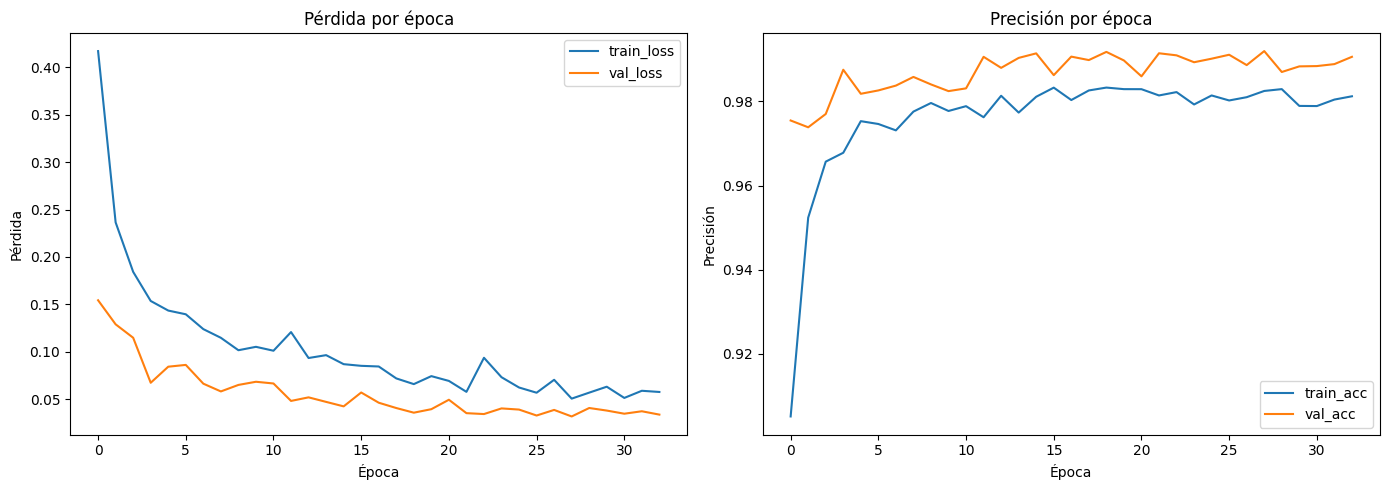

In [15]:
# ✅ Carga de modelo NN y entrenamiento modelo Regresion Logistica

# Entrenamiento y captura del history para graficar luego
import train
history = train.train(return_history=True)  # ← Aquí obtienes history directamente

# Red Neuronal
model_path = os.path.join(config["base_dir"], "models", "model.keras")
nn_model = load_model(model_path)
y_prob_nn = nn_model.predict(X_test_scaled).flatten()
y_prob_train_nn = nn_model.predict(X_train_scaled).flatten()
y_pred_nn = (y_prob_nn > 0.5).astype(int)

# Regresión Logística
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]
y_pred_lr = (y_prob_lr > 0.5).astype(int)

# Grafico Loss Function y Precision para la NN
plot_training(history)

In [16]:
# ✅ Evaluación: generación de métricas y visualizaciones

from sklearn.metrics import classification_report, roc_auc_score, roc_curve

print("🔎 Regressión Logística")
print(classification_report(y_test, y_pred_lr, target_names=["No Fraude", "Fraude"]))
print("AUC:", roc_auc_score(y_test, y_prob_lr))

print("\n🔎 Red Neuronal")
print(classification_report(y_test, y_pred_nn, target_names=["No Fraude", "Fraude"]))
print("AUC:", roc_auc_score(y_test, y_prob_nn))

🔎 Regressión Logística
              precision    recall  f1-score   support

   No Fraude       1.00      1.00      1.00     42648
      Fraude       0.92      0.64      0.75        74

    accuracy                           1.00     42722
   macro avg       0.96      0.82      0.88     42722
weighted avg       1.00      1.00      1.00     42722

AUC: 0.9564594138313891

🔎 Red Neuronal
              precision    recall  f1-score   support

   No Fraude       1.00      0.99      1.00     42648
      Fraude       0.17      0.84      0.28        74

    accuracy                           0.99     42722
   macro avg       0.58      0.92      0.64     42722
weighted avg       1.00      0.99      1.00     42722

AUC: 0.9706155226695463


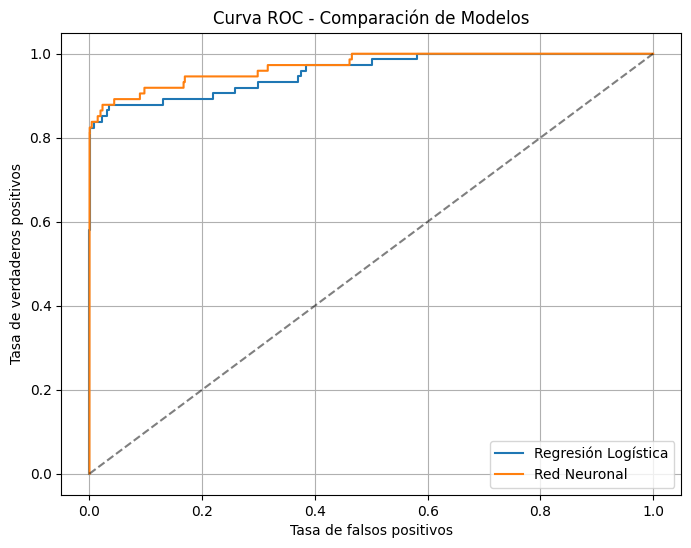

In [17]:
# ✅ Comparar curvas ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob_nn)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label="Regresión Logística")
plt.plot(fpr_nn, tpr_nn, label="Red Neuronal")
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("Curva ROC - Comparación de Modelos")
plt.legend()
plt.grid()
plt.show()

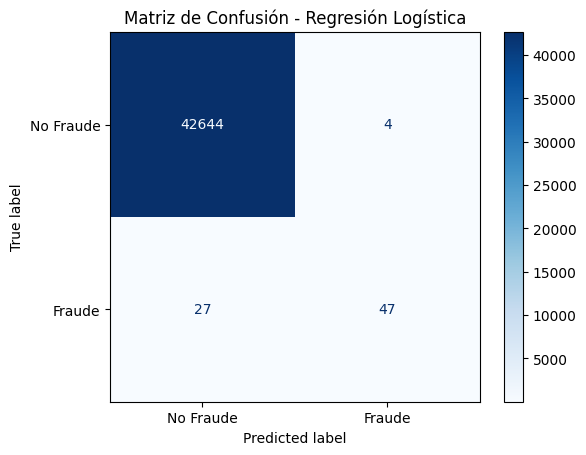

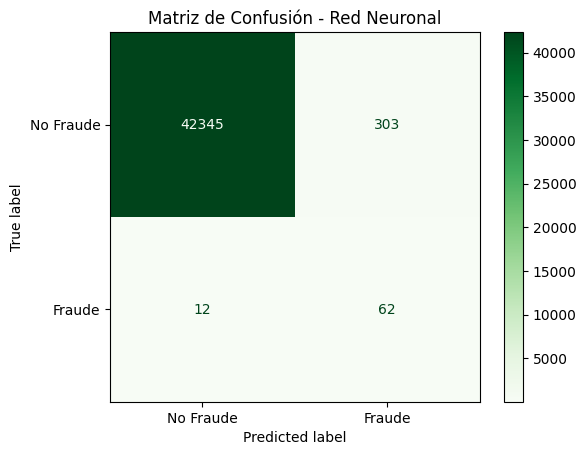

,Accuracy,Precision,Recall,F1-score,AUC
Modelo,,,,,
Regresión Logística,0.9993,0.9216,0.6351,0.7520,0.9565
Red Neuronal,0.9926,0.1699,0.8378,0.2825,0.9706


In [18]:
# ✅  Metricas de modelos

# Matrices de confusión
plot_confusion_matrix(y_test, y_pred_lr, model_name="Regresión Logística", cmap="Blues")
plot_confusion_matrix(y_test, y_pred_nn, model_name="Red Neuronal", cmap="Greens")

# Tabla de métricas
df_metrics = get_classification_metrics_df(
    y_test, y_pred_lr, y_prob_lr,
    y_test, y_pred_nn, y_prob_nn
)
display(df_metrics)

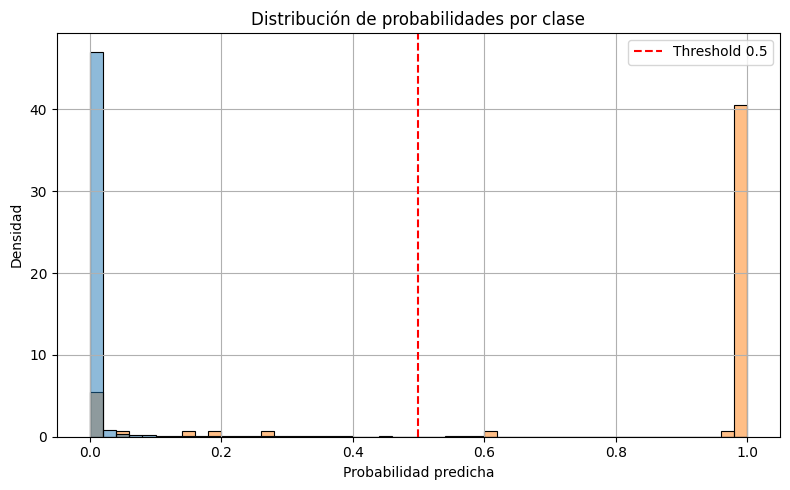

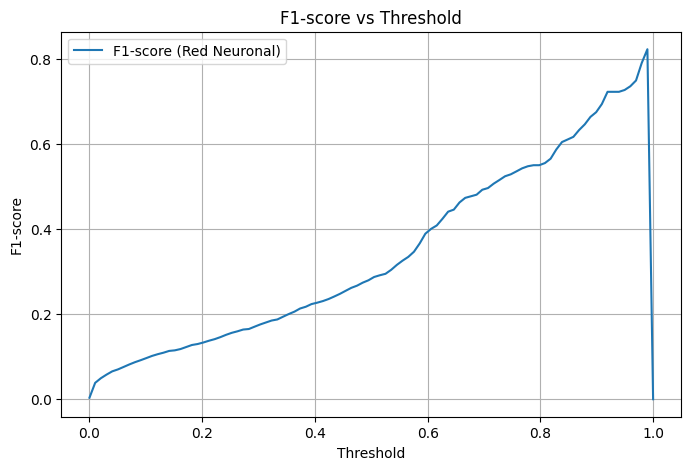

In [19]:
# ✅ Distribución de predicciones para NN
plot_prediction_distribution(y_test, y_prob_nn)
plot_f1_vs_threshold(y_test, y_prob_nn, modelo="Red Neuronal")

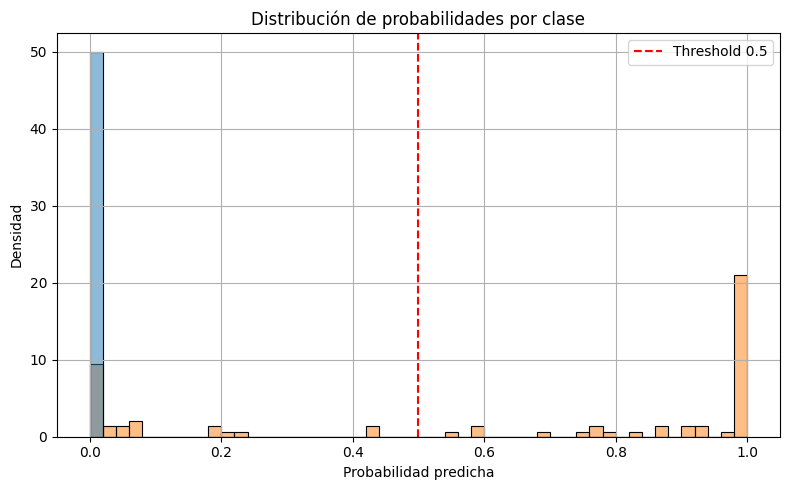

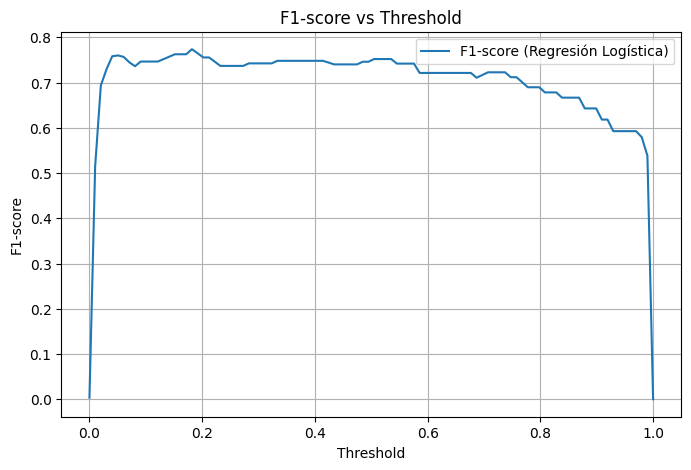

In [20]:
# ✅ Distribución de predicciones para Regresión Logística
plot_prediction_distribution(y_test, y_prob_lr)
plot_f1_vs_threshold(y_test, y_prob_lr, modelo="Regresión Logística")

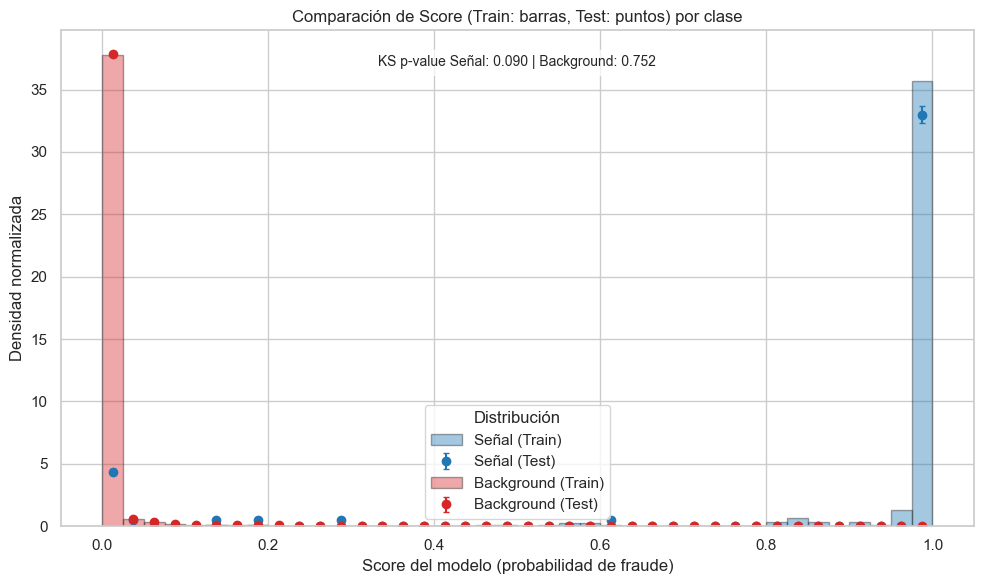

In [21]:
# ✅ Evaluación de sobreajuste en la red neuronal
plot_ks_overtraining(y_train, y_prob_train_nn, y_test, y_prob_nn)